# AI허브 건강관리를 위한 음식 이미지

In [ ]:
!nvidia-smi

Fri May 27 07:43:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
root_dir = '/content/drive/MyDrive'
base_dir = os.path.join(root_dir, 'data')
split_dir = {split_name:os.path.join(base_dir,split_name)
                for split_name in ['train','valid','test']}
os.chdir(root_dir)
random.seed = 42

In [ ]:
!unzip -qq data.zip

## Modeling

In [ ]:
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, Flatten, AveragePooling2D, Input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import layers, regularizers, optimizers
print(tf.__version__)

2.8.0


In [ ]:
!python --version

Python 3.7.13


## Make Generator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale= 1./255) 

train_generator = train_datagen.flow_from_directory(
    split_dir['train'],
    target_size = (299, 299),
    batch_size = 32,
    seed = 42
)

val_generator = val_datagen.flow_from_directory(
    split_dir['valid'],
    target_size = (299, 299),
    batch_size = 32,
    shuffle=True,
    seed = 42
)

test_generator = test_datagen.flow_from_directory(
    split_dir['test'],
    target_size = (299, 299),
    batch_size = 32,
    seed = 42
)

Found 81018 images belonging to 422 classes.
Found 23521 images belonging to 422 classes.
Found 11119 images belonging to 422 classes.


In [ ]:
for data_batch, labels_batch in train_generator:
    print('Batch data size:', data_batch.shape)
    print('Batch label size:', labels_batch.shape)
    break
print('Generator length:', len(train_generator))

Batch data size: (32, 299, 299, 3)
Batch label size: (32, 422)
Generator length: 2532


## Set Checkpoint Path

In [ ]:
from datetime import datetime
now = datetime.now().strftime('%y%m%d_%H%M%S')

model_dir = os.path.join(root_dir, 'model')
save_dir = os.path.join(model_dir, now)

if not(os.path.isdir(model_dir)):
    os.mkdir(model_dir)
os.mkdir(save_dir)

model_path = save_dir + '/{epoch:02d}-{val_accuracy:.4f}.hdf5'

## Add Output Layer

In [ ]:
import sys
sys.setrecursionlimit(10000)
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))
# base_model.trainable = False
x = base_model.output
x = AveragePooling2D(pool_size=(8, 8))(x)
x = Dropout(.2)(x)
x = Flatten()(x)
x = Dropout(.2)(x)
predictions = layers.Dense(422,kernel_initializer='glorot_uniform', 
                        kernel_regularizer=regularizers.l2(.0005), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

87924736/87910968 [==============================] - 0s 0us/step


## Load Checkpoint

In [ ]:
# from tensorflow.keras import models
# model = models.load_model('./04-0.4752.hdf5')

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_accuracy',
                                verbose=1, save_best_only=True)

## Train

In [ ]:
# Start with learning rate 0.005
history = model.fit(train_generator,
                    epochs=5, steps_per_epoch= len(train_generator), 
                    validation_data = val_generator,
                    validation_steps= len(val_generator),
                    use_multiprocessing=True,
                    callbacks=[cb_checkpoint, early_stopping]
                    )

Epoch 1/5
2532/2532 [==============================] - ETA: 0s - loss: 5.8183 - accuracy: 0.0126
Epoch 1: val_accuracy improved from -inf to 0.02355, saving model to /content/drive/MyDrive/inception/model/220527_075818/01-0.0236.hdf5
2532/2532 [==============================] - 2681s 1s/step - loss: 5.8183 - accuracy: 0.0126 - val_loss: 5.6666 - val_accuracy: 0.0236
Epoch 2/5
2532/2532 [==============================] - ETA: 0s - loss: 4.8439 - accuracy: 0.0662
Epoch 2: val_accuracy improved from 0.02355 to 0.05650, saving model to /content/drive/MyDrive/inception/model/220527_075818/02-0.0565.hdf5
2532/2532 [==============================] - 2476s 978ms/step - loss: 4.8439 - accuracy: 0.0662 - val_loss: 5.5205 - val_accuracy: 0.0565
Epoch 3/5
2532/2532 [==============================] - ETA: 0s - loss: 4.1458 - accuracy: 0.1524
Epoch 3: val_accuracy improved from 0.05650 to 0.16279, saving model to /content/drive/MyDrive/inception/model/220527_075818/03-0.1628.hdf5
2532/2532 [========

In [ ]:
# After 5epoch, change learning rate to 0.0005
history = model.fit(train_generator,
                    epochs=5, steps_per_epoch= len(train_generator), 
                    validation_data = val_generator,
                    validation_steps= len(val_generator),
                    use_multiprocessing=True,
                    callbacks=[cb_checkpoint, early_stopping]
                    )

Epoch 1/5
2532/2532 [==============================] - ETA: 0s - loss: 2.8664 - accuracy: 0.3938
Epoch 1: val_accuracy improved from -inf to 0.41907, saving model to /content/drive/MyDrive/inception/model/220527_114534/01-0.4191.hdf5
2532/2532 [==============================] - 2466s 965ms/step - loss: 2.8664 - accuracy: 0.3938 - val_loss: 2.7278 - val_accuracy: 0.4191
Epoch 2/5
2532/2532 [==============================] - ETA: 0s - loss: 2.6297 - accuracy: 0.4370
Epoch 2: val_accuracy improved from 0.41907 to 0.45270, saving model to /content/drive/MyDrive/inception/model/220527_114534/02-0.4527.hdf5
2532/2532 [==============================] - 2470s 975ms/step - loss: 2.6297 - accuracy: 0.4370 - val_loss: 2.5538 - val_accuracy: 0.4527
Epoch 3/5
2532/2532 [==============================] - ETA: 0s - loss: 2.4562 - accuracy: 0.4699
Epoch 3: val_accuracy improved from 0.45270 to 0.47702, saving model to /content/drive/MyDrive/inception/model/220527_114534/03-0.4770.hdf5
2532/2532 [=====

In [ ]:
history = model.fit(train_generator,
                    epochs=5, steps_per_epoch= len(train_generator), 
                    validation_data = val_generator,
                    validation_steps= len(val_generator),
                    use_multiprocessing=True,
                    callbacks=[cb_checkpoint, early_stopping]
                    )

Epoch 1/5
2532/2532 [==============================] - ETA: 0s - loss: 2.3404 - accuracy: 0.5042
Epoch 1: val_accuracy improved from -inf to 0.51333, saving model to /content/drive/MyDrive/Final/inception/model/220528_043655/01-0.5133.hdf5
2532/2532 [==============================] - 2473s 966ms/step - loss: 2.3404 - accuracy: 0.5042 - val_loss: 2.2561 - val_accuracy: 0.5133
Epoch 2/5
2532/2532 [==============================] - ETA: 0s - loss: 2.1862 - accuracy: 0.5314
Epoch 2: val_accuracy did not improve from 0.51333
2532/2532 [==============================] - 2405s 950ms/step - loss: 2.1862 - accuracy: 0.5314 - val_loss: 2.4653 - val_accuracy: 0.4768
Epoch 3/5
2532/2532 [==============================] - ETA: 0s - loss: 2.0805 - accuracy: 0.5525
Epoch 3: val_accuracy improved from 0.51333 to 0.55512, saving model to /content/drive/MyDrive/Final/inception/model/220528_043655/03-0.5551.hdf5
2532/2532 [==============================] - 2462s 972ms/step - loss: 2.0805 - accuracy: 0.55

In [ ]:
history = model.fit(train_generator,
                    epochs=10, steps_per_epoch= len(train_generator), 
                    validation_data = val_generator,
                    validation_steps= len(val_generator),
                    use_multiprocessing=True,
                    callbacks=[cb_checkpoint, early_stopping]
                    )

Epoch 1/10
2532/2532 [==============================] - ETA: 0s - loss: 1.9094 - accuracy: 0.5964
Epoch 1: val_accuracy improved from -inf to 0.55478, saving model to /content/drive/MyDrive/model/220528_092640/01-0.5548.hdf5
2532/2532 [==============================] - 2470s 966ms/step - loss: 1.9094 - accuracy: 0.5964 - val_loss: 2.1284 - val_accuracy: 0.5548
Epoch 2/10
2532/2532 [==============================] - ETA: 0s - loss: 1.8003 - accuracy: 0.6166
Epoch 2: val_accuracy improved from 0.55478 to 0.59874, saving model to /content/drive/MyDrive/model/220528_092640/02-0.5987.hdf5
2532/2532 [==============================] - 2407s 950ms/step - loss: 1.8003 - accuracy: 0.6166 - val_loss: 1.8941 - val_accuracy: 0.5987
Epoch 3/10
2532/2532 [==============================] - ETA: 0s - loss: 1.7182 - accuracy: 0.6352
Epoch 3: val_accuracy improved from 0.59874 to 0.61422, saving model to /content/drive/MyDrive/model/220528_092640/03-0.6142.hdf5
2532/2532 [==============================] 

In [ ]:
history = model.fit(train_generator,
                    epochs=5, steps_per_epoch= len(train_generator), 
                    validation_data = val_generator,
                    validation_steps= len(val_generator),
                    use_multiprocessing=True,
                    callbacks=[cb_checkpoint, early_stopping]
                    )

Epoch 1/5
2532/2532 [==============================] - ETA: 0s - loss: 1.6675 - accuracy: 0.6506
Epoch 1: val_accuracy improved from -inf to 0.59190, saving model to /content/drive/MyDrive/inception/model/220529_031005/01-0.5919.hdf5
2532/2532 [==============================] - 2480s 970ms/step - loss: 1.6675 - accuracy: 0.6506 - val_loss: 1.9530 - val_accuracy: 0.5919
Epoch 2/5
2532/2532 [==============================] - ETA: 0s - loss: 1.5833 - accuracy: 0.6659
Epoch 2: val_accuracy did not improve from 0.59190
2532/2532 [==============================] - 2406s 950ms/step - loss: 1.5833 - accuracy: 0.6659 - val_loss: 2.1770 - val_accuracy: 0.5532
Epoch 3/5
2532/2532 [==============================] - ETA: 0s - loss: 1.5073 - accuracy: 0.6829
Epoch 3: val_accuracy improved from 0.59190 to 0.62969, saving model to /content/drive/MyDrive/inception/model/220529_031005/03-0.6297.hdf5
2532/2532 [==============================] - 2374s 937ms/step - loss: 1.5073 - accuracy: 0.6829 - val_los

In [ ]:
history = model.fit(train_generator,
                    epochs=5, steps_per_epoch= len(train_generator), 
                    validation_data = val_generator,
                    validation_steps= len(val_generator),
                    use_multiprocessing=True,
                    callbacks=[cb_checkpoint, early_stopping]
                    )

Epoch 1/5
2532/2532 [==============================] - ETA: 0s - loss: 1.3692 - accuracy: 0.7203
Epoch 1: val_accuracy improved from -inf to 0.62200, saving model to /content/drive/MyDrive/Final/inception/model/220529_070421/01-0.6220.hdf5
2532/2532 [==============================] - 2534s 992ms/step - loss: 1.3692 - accuracy: 0.7203 - val_loss: 1.9107 - val_accuracy: 0.6220
Epoch 2/5
2532/2532 [==============================] - ETA: 0s - loss: 1.3035 - accuracy: 0.7320
Epoch 2: val_accuracy improved from 0.62200 to 0.64372, saving model to /content/drive/MyDrive/Final/inception/model/220529_070421/02-0.6437.hdf5
2532/2532 [==============================] - 2465s 973ms/step - loss: 1.3035 - accuracy: 0.7320 - val_loss: 1.7450 - val_accuracy: 0.6437
Epoch 3/5
2532/2532 [==============================] - ETA: 0s - loss: 1.2527 - accuracy: 0.7410
Epoch 3: val_accuracy did not improve from 0.64372
2532/2532 [==============================] - 2470s 975ms/step - loss: 1.2527 - accuracy: 0.74

In [ ]:
# After slow down, change learning rate to 0.0001
history = model.fit(train_generator,
                    epochs=7, steps_per_epoch= len(train_generator), 
                    validation_data = val_generator,
                    validation_steps= len(val_generator),
                    use_multiprocessing=True,
                    callbacks=[cb_checkpoint, early_stopping]
                    )

Epoch 1/7
2532/2532 [==============================] - ETA: 0s - loss: 0.9665 - accuracy: 0.8224
Epoch 1: val_accuracy improved from -inf to 0.71251, saving model to /content/drive/MyDrive/model/220530_003956/01-0.7125.hdf5
2532/2532 [==============================] - 2444s 956ms/step - loss: 0.9665 - accuracy: 0.8224 - val_loss: 1.4090 - val_accuracy: 0.7125
Epoch 2/7
2532/2532 [==============================] - ETA: 0s - loss: 0.8647 - accuracy: 0.8459
Epoch 2: val_accuracy improved from 0.71251 to 0.71319, saving model to /content/drive/MyDrive/model/220530_003956/02-0.7132.hdf5
2532/2532 [==============================] - 2407s 951ms/step - loss: 0.8647 - accuracy: 0.8459 - val_loss: 1.4091 - val_accuracy: 0.7132
Epoch 3/7
2532/2532 [==============================] - ETA: 0s - loss: 0.8632 - accuracy: 0.8384
Epoch 3: val_accuracy improved from 0.71319 to 0.71625, saving model to /content/drive/MyDrive/model/220530_003956/03-0.7163.hdf5
2532/2532 [==============================] - 2

In [ ]:
history = model.fit(train_generator,
                    epochs=5, steps_per_epoch= len(train_generator), 
                    validation_data = val_generator,
                    validation_steps= len(val_generator),
                    use_multiprocessing=True,
                    callbacks=[cb_checkpoint, early_stopping]
                    )

Epoch 1/5
2532/2532 [==============================] - ETA: 0s - loss: 0.7428 - accuracy: 0.8683
Epoch 1: val_accuracy improved from -inf to 0.71817, saving model to /content/drive/MyDrive/inception/model/220530_050333/01-0.7182.hdf5
2532/2532 [==============================] - 2445s 956ms/step - loss: 0.7428 - accuracy: 0.8683 - val_loss: 1.3701 - val_accuracy: 0.7182
Epoch 2/5
2532/2532 [==============================] - ETA: 0s - loss: 0.7046 - accuracy: 0.8758
Epoch 2: val_accuracy improved from 0.71817 to 0.72501, saving model to /content/drive/MyDrive/inception/model/220530_050333/02-0.7250.hdf5
2532/2532 [==============================] - 2372s 937ms/step - loss: 0.7046 - accuracy: 0.8758 - val_loss: 1.3516 - val_accuracy: 0.7250
Epoch 3/5
2532/2532 [==============================] - ETA: 0s - loss: 0.7146 - accuracy: 0.8703
Epoch 3: val_accuracy improved from 0.72501 to 0.72527, saving model to /content/drive/MyDrive/inception/model/220530_050333/03-0.7253.hdf5
2532/2532 [=====

In [ ]:
history = model.fit(train_generator,
                    epochs=5, steps_per_epoch= len(train_generator), 
                    validation_data = val_generator,
                    validation_steps= len(val_generator),
                    use_multiprocessing=True,
                    callbacks=[cb_checkpoint, early_stopping]
                    )

Epoch 1/5
2532/2532 [==============================] - ETA: 0s - loss: 0.6898 - accuracy: 0.8718
Epoch 1: val_accuracy did not improve from 0.72752
2532/2532 [==============================] - 2408s 951ms/step - loss: 0.6898 - accuracy: 0.8718 - val_loss: 1.3749 - val_accuracy: 0.7191
Epoch 2/5
2532/2532 [==============================] - ETA: 0s - loss: 0.6689 - accuracy: 0.8766
Epoch 2: val_accuracy improved from 0.72752 to 0.72948, saving model to /content/drive/MyDrive/inception/model/220530_050333/02-0.7295.hdf5
2532/2532 [==============================] - 2341s 924ms/step - loss: 0.6689 - accuracy: 0.8766 - val_loss: 1.3278 - val_accuracy: 0.7295
Epoch 3/5
2532/2532 [==============================] - ETA: 0s - loss: 0.6565 - accuracy: 0.8789
Epoch 3: val_accuracy did not improve from 0.72948
2532/2532 [==============================] - 2358s 931ms/step - loss: 0.6565 - accuracy: 0.8789 - val_loss: 1.3403 - val_accuracy: 0.7254
Epoch 4/5
2532/2532 [==============================] 

In [ ]:
history = model.fit(train_generator,
                    epochs=5, steps_per_epoch= len(train_generator), 
                    validation_data = val_generator,
                    validation_steps= len(val_generator),
                    use_multiprocessing=True,
                    callbacks=[cb_checkpoint, early_stopping]
                    )

Epoch 1/5
2532/2532 [==============================] - ETA: 0s - loss: 0.6040 - accuracy: 0.8981
Epoch 1: val_accuracy improved from -inf to 0.71829, saving model to /content/drive/MyDrive/Final/inception/model/220530_113047/01-0.7183.hdf5
2532/2532 [==============================] - 2483s 971ms/step - loss: 0.6040 - accuracy: 0.8981 - val_loss: 1.3830 - val_accuracy: 0.7183
Epoch 2/5
2532/2532 [==============================] - ETA: 0s - loss: 0.5817 - accuracy: 0.9024
Epoch 2: val_accuracy improved from 0.71829 to 0.72374, saving model to /content/drive/MyDrive/Final/inception/model/220530_113047/02-0.7237.hdf5
2532/2532 [==============================] - 2429s 959ms/step - loss: 0.5817 - accuracy: 0.9024 - val_loss: 1.3613 - val_accuracy: 0.7237
Epoch 3/5
2532/2532 [==============================] - ETA: 0s - loss: 0.6296 - accuracy: 0.8849
Epoch 3: val_accuracy improved from 0.72374 to 0.73254, saving model to /content/drive/MyDrive/Final/inception/model/220530_113047/03-0.7325.hdf

## Show History

In [ ]:
history.history

In [1]:
history = dict()
history['accuracy'] = [0.0126, 0.0662, 0.1524, 0.2285, 0.2976, 0.3938, 0.4370, 0.4699, 0.5042, 0.5314, 0.5525, 0.5740, 0.5964, 0.6166, 0.6352, 0.6506, 0.6659, 0.6829, 0.6837, 0.6998, 0.7203, 0.7320, 0.7410, 0.8224, 0.8459, 0.8384, 0.8389, 0.8436, 0.8683, 0.8758, 0.8703, 0.8696, 0.8720, 0.8718, 0.8766, 0.8981, 0.9024, 0.8849]
history['val_accuracy'] = [0.0236, 0.0565, 0.1628, 0.2339, 0.2933, 0.4191, 0.4527, 0.4770, 0.5133, 0.4768, 0.5551, 0.5699, 0.5548, 0.5987, 0.6142, 0.5919, 0.5532, 0.6297, 0.5991, 0.6439, 0.6220, 0.6437, 0.6331, 0.7125, 0.7132, 0.7163, 0.7217, 0.7230, 0.7182, 0.7250, 0.7253, 0.7215, 0.7275, 0.7191, 0.7295, 0.7183, 0.7237, 0.7325]
history['loss'] = [5.8183, 4.8439, 4.1458, 3.6869, 3.3154, 2.8664, 2.6297, 2.4562, 2.3404, 2.1862, 2.0805, 1.9696, 1.9094, 1.8003, 1.7182, 1.6675, 1.5833, 1.5073, 1.4955, 1.4202, 1.3692, 1.3035, 1.2527, 0.9665, 0.8647, 0.8632, 0.8469, 0.8225, 0.7428, 0.7046, 0.7146, 0.7091, 0.6942, 0.6898, 0.6689, 0.6040, 0.5817, 0.6296]
history['val_loss'] = [5.6666, 5.5205, 4.2405, 3.7667, 3.3760, 2.7278, 2.5538, 2.4203, 2.2561, 2.4653, 2.0630, 2.0083, 2.1284, 1.8941, 1.8321, 1.9530, 2.1770, 1.7598, 1.9594, 1.7687, 1.9107, 1.7450, 1.8237, 1.4090, 1.4091, 1.3927, 1.3617, 1.3517, 1.3701, 1.3516, 1.3428, 1.3604, 1.3389, 1.3749, 1.3278, 1.3830, 1.3613, 1.3358]

In [2]:
import pandas as pd

pd.DataFrame(history)

,accuracy,val_accuracy,loss,val_loss
0,0.0126,0.0236,5.8183,5.6666
1,0.0662,0.0565,4.8439,5.5205
2,0.1524,0.1628,4.1458,4.2405
3,0.2285,0.2339,3.6869,3.7667
4,0.2976,0.2933,3.3154,3.3760
5,0.3938,0.4191,2.8664,2.7278
6,0.4370,0.4527,2.6297,2.5538
7,0.4699,0.4770,2.4562,2.4203
8,0.5042,0.5133,2.3404,2.2561
9,0.5314,0.4768,2.1862,2.4653


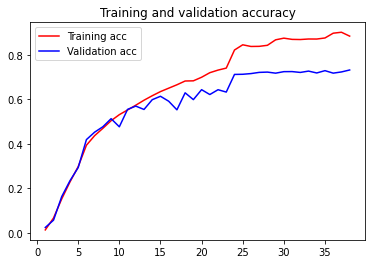

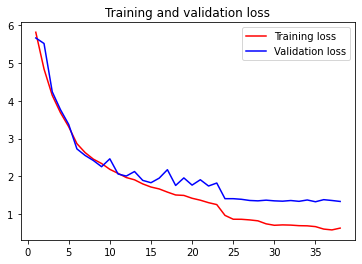

In [3]:
import matplotlib.pyplot as plt

# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label="Training acc")
plt.plot(epochs, val_acc, 'b', label="Validation acc")
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

## Save Model

In [ ]:
model.save('best_model.h5')

In [ ]:
from tensorflow.keras import models
model = models.load_model('best_model.h5')

## Evaluate

In [ ]:
val_datagen = ImageDataGenerator(rescale = 1./255)

val_generator = val_datagen.flow_from_directory(
    split_dir['valid'],
    target_size = (299, 299),
    batch_size = 32,
    shuffle=True,
    seed = 42
)

val_prediction = model.evaluate(val_generator, steps=len(val_generator))

Found 23521 images belonging to 422 classes.
736/736 [==============================] - 116s 157ms/step - loss: 3.3760 - accuracy: 0.2933


In [ ]:
len(val_prediction)

2

## Predict

In [ ]:
food_classes = val_generator.class_indices
print(food_classes)

{'가리비': 0, '가지': 1, '가지구이': 2, '가츠동': 3, '간장': 4, '갈비구이': 5, '갈비탕': 6, '감': 7, '감귤주스': 8, '감자구이': 9, '감자그라탕': 10, '감자볶음': 11, '감자샐러드': 12, '감자스프': 13, '감자칩': 14, '감자튀김': 15, '거봉포도': 16, '건자두': 17, '건포도': 18, '게맛살': 19, '게장': 20, '겨자소스': 21, '경단': 22, '계란말이': 23, '계란볶음밥': 24, '계란샌드위치': 25, '계란찜': 26, '계란후라이': 27, '고구마': 28, '고등어': 29, '고등어구이': 30, '고르곤졸라': 31, '고르곤졸라피자': 32, '고추': 33, '고추장': 34, '고추장아찌': 35, '고춧가루': 36, '골드키위': 37, '곶감': 38, '과일주스': 39, '과일채소샐러드': 40, '구아바': 41, '국수': 42, '국화차': 43, '군고구마': 44, '귤': 45, '그라탕': 46, '그린올리브': 47, '김': 48, '김마끼': 49, '김밥': 50, '김치국': 51, '김치볶음밥': 52, '김치찌개': 53, '까르보나라': 54, '까망베르치즈': 55, '껌': 56, '꿀': 57, '나시고랭': 58, '낫또': 59, '냉면': 60, '녹즙': 61, 

In [ ]:
import numpy as np
import cv2

food_classes = {v:k for k,v in food_classes.items()}